# Chapter 04: Custom Datasets
We've used some custom datasets before, how do we get our own data into pytorch?


In [75]:
from operator import truediv

import torch
from fontTools.merge import timer
from torch import nn

torch.__version__

'2.7.1'

In [76]:
import torch

# Set device to MPS if available
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

# Create tensors or models on the MPS device
x = torch.randn(4, 4).to(device)
x.device

device(type='mps', index=0)

## 1. Get data


In [77]:
import requests
import zipfile
from pathlib import Path

# Setup path to a data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

if image_path.is_dir():
    print(f"{image_path} already exists")
else:
    print(f"{image_path} does not exist, creating new one...")
    image_path.mkdir(parents=True, exist_ok=True)

# Download data
with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
    r = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    f.write(r.content)
# Unzip data
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
    print("Unzipping data")
    zip_ref.extractall(image_path)


data/pizza_steak_sushi already exists
Unzipping data


## 2. Data prep and exploration

In [78]:
import os
def walk_through_dir(dir_path):
    # Walks through dir_path returing the contents
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are : {len(dirnames)} directories and {len(filenames)} images in {dirpath}")

In [79]:
walk_through_dir(image_path)

There are : 2 directories and 0 images in data/pizza_steak_sushi
There are : 3 directories and 0 images in data/pizza_steak_sushi/test
There are : 0 directories and 19 images in data/pizza_steak_sushi/test/steak
There are : 0 directories and 31 images in data/pizza_steak_sushi/test/sushi
There are : 0 directories and 25 images in data/pizza_steak_sushi/test/pizza
There are : 3 directories and 0 images in data/pizza_steak_sushi/train
There are : 0 directories and 75 images in data/pizza_steak_sushi/train/steak
There are : 0 directories and 72 images in data/pizza_steak_sushi/train/sushi
There are : 0 directories and 78 images in data/pizza_steak_sushi/train/pizza


In [80]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"


### 2.1 Visualizing an image
1. get all the image paths
2. Pick a random path using random.choice()
3. Get the class name using 'pathlib.Path.parent.stem'
4. Since we're working with images, lets open th pyhtons PIL
5. SHow image and print metadata

Random image path: data/pizza_steak_sushi/test/pizza/2236338.jpg
Image class: pizza
Image height: 512
Image width: 512


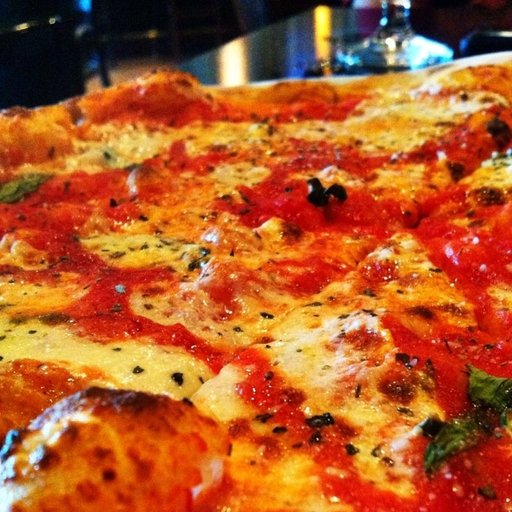

In [81]:
import random
from PIL import Image

# Set seed
random.seed(42)
# 1. get all image paths
image_path_list =list(image_path.glob("*/*/*.jpg"))

# 2. Pick random image path
random_image_path = random.choice(image_path_list)

# 3.Get the image class from path name (the image class is the name of the directory where the image is stored_
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

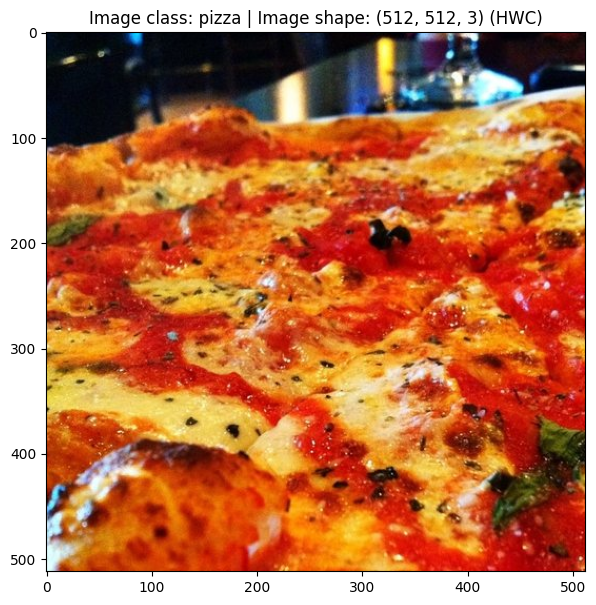

In [82]:
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} (HWC)")
plt.show()

## 3. Transforming data (jpg to tensors)
Images must be converted to tnesors before training!

In [83]:
import torch
from torch.utils.data.dataset import Dataset
from torchvision import transforms


In [84]:
# Write a transform for image
data_transform = transforms.Compose([
    # Resize the data
    transforms.Resize(size=(64,64)),
    # Flip the images randomly on the horizontal axis
    transforms.RandomHorizontalFlip(p=0.5),
    # Turn the image into a torch tensor
    transforms.ToTensor()
])

In [85]:
data_transform(img)

tensor([[[0.1020, 0.1922, 0.2314,  ..., 0.0118, 0.0157, 0.0157],
         [0.1216, 0.1059, 0.1137,  ..., 0.0157, 0.0157, 0.0157],
         [0.1569, 0.1255, 0.1098,  ..., 0.0941, 0.0235, 0.0157],
         ...,
         [0.6902, 0.6353, 0.4353,  ..., 0.8039, 0.8275, 0.8549],
         [0.7412, 0.6235, 0.4824,  ..., 0.7922, 0.8392, 0.8667],
         [0.8000, 0.6549, 0.6627,  ..., 0.7255, 0.7333, 0.8627]],

        [[0.0392, 0.0471, 0.0510,  ..., 0.0392, 0.0510, 0.0588],
         [0.0549, 0.0431, 0.0431,  ..., 0.0431, 0.0471, 0.0549],
         [0.0510, 0.0471, 0.0510,  ..., 0.1176, 0.0706, 0.0667],
         ...,
         [0.0627, 0.0627, 0.1098,  ..., 0.8118, 0.8824, 0.9529],
         [0.2353, 0.0824, 0.0667,  ..., 0.6353, 0.8510, 0.9804],
         [0.3098, 0.0980, 0.0745,  ..., 0.3176, 0.5451, 0.9412]],

        [[0.0392, 0.0510, 0.0588,  ..., 0.0667, 0.0745, 0.1176],
         [0.0510, 0.0392, 0.0431,  ..., 0.0784, 0.0863, 0.1137],
         [0.0627, 0.0510, 0.0588,  ..., 0.1216, 0.0941, 0.

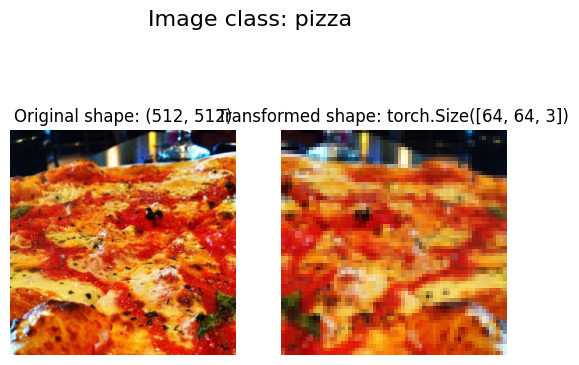

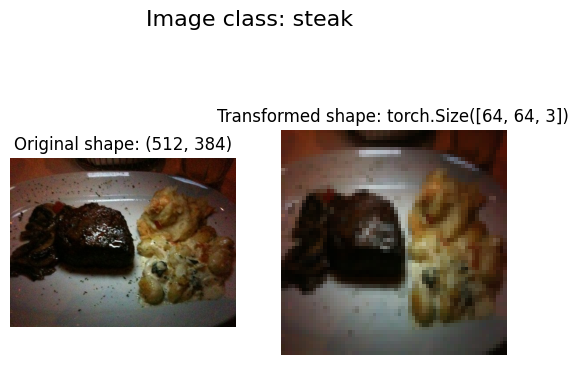

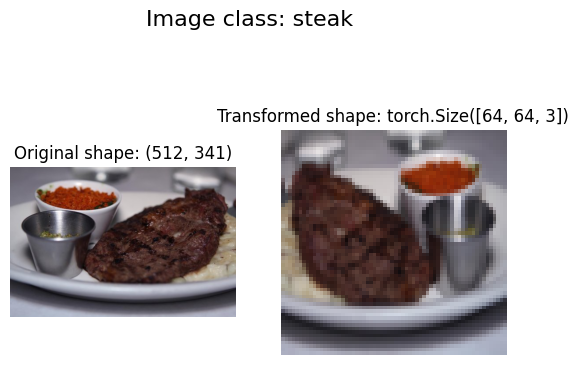

In [86]:
def plot_transformed_images(image_paths, transform, n=3, seed = 42):
    # Selects random images from a apath and transforms them, then plots the original vs transformed version
    if seed:
        random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as img:
            fig, ax = plt.subplots(nrows=1, ncols=2)
            ax[0].imshow(img)
            ax[0].set_title(f"Original shape: {img.size}")
            ax[0].axis(False)

            # Transform and plot target iamge
            transformed_image = transform(img).permute(1, 2, 0) # (C, H, W)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed shape: {transformed_image.shape}")
            ax[1].axis(False)

            fig.suptitle(f"Image class: {image_path.parent.stem}", fontsize=16)
plot_transformed_images(image_path_list, data_transform, n=3, seed=42)

## 4. Option 1: Loading image data usig data folder
We can load image classification data using 'torchvision.datasets.ImageFolder'


In [87]:
# Using ImageFolder to create datasets(s)
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform, # A transform for the data
                                  target_transform=None) # A transform for the label/target
test_data = datasets.ImageFolder(root=test_dir,
                                  transform=data_transform, # A transform for the data
                                  target_transform=None) # A transform for the label/target
train_data, test_data


(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [88]:
# Get clas names as a list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [89]:
# Check the lengths of the dataset
len(train_data), len(test_data)

(225, 75)

In [90]:
train_data.samples[0]

('data/pizza_steak_sushi/train/pizza/1008844.jpg', 0)

In [91]:
# Index on the train_data Dataset to get a single image and label
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n {img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
 tensor([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
         [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
         [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
         ...,
         [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
         [0.0902, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]],

        [[0.0745, 0.0706, 0.0745,  ..., 0.0588, 0.0588, 0.0588],
         [0.0745, 0.0706, 0.0745,  ..., 0.0627, 0.0627, 0.0627],
         [0.0706, 0.0745, 0.0745,  ..., 0.0706, 0.0706, 0.0706],
         ...,
         [0.1255, 0.1333, 0.1373,  ..., 0.2510, 0.2392, 0.2392],
         [0.1098, 0.1176, 0.1255,  ..., 0.2510, 0.2392, 0.2314],
         [0.1020, 0.1059, 0.1137,  ..., 0.2431, 0.2353, 0.2275]],

        [[0.0941, 0.0902, 0.0902,  ..., 0.0157, 0.0196, 0.0196],
         [0.0902, 0.0863, 0.0902,  ..., 0.0196, 0.0157, 0.0196],
         [0.0902, 0.0902, 0.0902,  ..., 0.0

Original shape: torch.Size([3, 64, 64]) -> [color_channels, height, width]
Permuted shape: torch.Size([64, 64, 3]) -> [height, width, color_channels]


Text(0.5, 1.0, 'pizza')

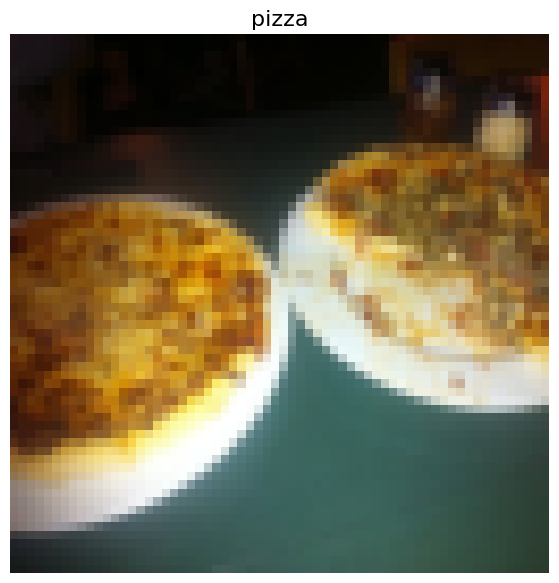

In [92]:
# Rearrange the order dimensions
img_permute = img.permute(1, 2, 0)

# Print out different shapes
print(f"Original shape: {img.shape} -> [color_channels, height, width]")
print(f"Permuted shape: {img_permute.shape} -> [height, width, color_channels]")

# Plot the image
plt.figure(figsize=(10, 7))
plt.imshow(img_permute)
plt.axis("off")
plt.title(class_names[label], fontsize=16)

## 4.1 Turn loaded images into 'DataLoader's'


In [93]:
import os
os.cpu_count()

8

In [94]:
#!nvidia-smi

# Turn train and test datasets into DataLoader's
from torch.utils.data import DataLoader, dataloader

train_DataLoader = DataLoader(dataset=train_data,
                          batch_size=32,
                          num_workers=os.cpu_count(),
                          shuffle=True)
test_DataLoader = DataLoader(dataset=test_data,
                             batch_size=32,
                             num_workers=os.cpu_count(),
                             shuffle=False)


In [95]:
len(train_DataLoader), len(test_DataLoader)

(8, 3)

In [96]:
img, label = next(iter(train_DataLoader))

# Batch size will now be 1, you can now change the batch size if you want
print(f"Image shape: {img.shape} -> [Batch_size, color_channels, hieght, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([32, 3, 64, 64]) -> [Batch_size, color_channels, hieght, width]
Label shape: torch.Size([32])


## 5. OPTION 2: LOADING IMAGE DATA WITH A CUSTOM 'DATASET'

Pros:
* Can create a dataset out of anything
* Not limited to Pytorches prebuilt dataset function
<br><br>Cons:
* Not all data will work
*





In [97]:
from torch.utils.data.dataset import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List


In [98]:
# Instance of torchvision

In [99]:
print(torch.backends.mps.is_available())  # True if you can use Mac GPU
print(torch.backends.mps.is_built())      # True if PyTorch has MPS support


True
True


In [100]:
# Instance of trochvision.datasets.ImageFolder()
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.1 Creating a helper function to get class names
Need a function to:
1. Get the class names using 'os.scandir()' to traverse a target directory
2. Raise an error if the class names aren't found
3. Turn the class names into a dict and a list and return them

In [101]:
# Setup path for target directory
target_directory = train_dir
print(f"Target fir: {target_directory}")

# Get the class names from the target directory
class_names_found = sorted([entry.name for entry in list(os.scandir(target_directory))])
class_names_found

Target fir: data/pizza_steak_sushi/train


['pizza', 'steak', 'sushi']

In [102]:
def find_classes(directory: str) -> Tuple[list[str], Dict[str, int]]:
    # Finds the class folder names in a target directoy
    # 1. get the class names by scanning the target directory
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

    # 2. Raise an error if class names could not be found
    if not classes:
        raise FileNotFoundError(f" Could not find any classes in {directory}")
    # 3. Create a dictionary of index labels (computers prefer numbers rather than strings as labels)
    class_to_idx = {class_name: i for i, class_name in enumerate(classes)}
    return classes, class_to_idx



In [103]:
find_classes(target_directory)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.2 Create a custom 'Dataset' to replicate 'ImageFolder'
To create a custom dataset, one must:
1. Subclass 'torch.util.data.Dataset'
2. Init the subclass with a target directory as well as a transform if needed
3. Create several attributes
* Paths
* transforms
* classes
* class_to_idx
4. Create a function to load image
5. Overwrite the '__len()__' method

In [104]:
import pathlib
# Write a custom dataset class (inherits from torch.utils.data.Dataset)
from torch.utils.data import Dataset

# 1. Subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset):

    # 2. Initialize with a targ_dir and transform (optional) parameter
    def __init__(self, targ_dir: str, transform=None) -> None:

        # 3. Create class attributes
        # Get all image paths
        self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg")) # note: you'd have to update this if you've got .png's or .jpeg's
        # Setup transforms
        self.transform = transform
        # Create classes and class_to_idx attributes
        self.classes, self.class_to_idx = find_classes(targ_dir)

    # 4. Make function to load images
    def load_image(self, index: int) -> Image.Image:
        "Opens an image via a path and returns it."
        image_path = self.paths[index]
        return Image.open(image_path)

    # 5. Overwrite the __len__() method (optional but recommended for subclasses of torch.utils.data.Dataset)
    def __len__(self) -> int:
        "Returns the total number of samples."
        return len(self.paths)

    # 6. Overwrite the __getitem__() method (required for subclasses of torch.utils.data.Dataset)
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        "Returns one sample of data, data and label (X, y)."
        img = self.load_image(index)
        class_name  = self.paths[index].parent.name # expects path in data_folder/class_name/image.jpeg
        class_idx = self.class_to_idx[class_name]

        # Transform if necessary
        if self.transform:
            return self.transform(img), class_idx # return data, label (X, y)
        else:
            return img, class_idx # return data, label (X, y)

In [105]:
# Creat a trnasforms
train_transforms = transforms.Compose([
                                        transforms.Resize(size=(64, 64)),
                                        transforms.RandomHorizontalFlip(p=.5),
                                        transforms.ToTensor()
])

test_transforms = transforms.Compose([
                                        transforms.Resize(size=(64, 64)),
                                        transforms.ToTensor()
])


In [106]:
train_data_custom = ImageFolderCustom(targ_dir=train_dir,
                                      transform=train_transforms)
test_data_custom = ImageFolderCustom(targ_dir=test_dir,
                                     transform=test_transforms)
train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x12ad95e80>,
 <__main__.ImageFolderCustom at 0x12ad97a10>)

In [107]:
len(train_data), len(train_data_custom)

(225, 225)

In [108]:
len(test_data), len(test_data_custom)

(75, 75)

### 5.3 Create a function to display radnom images
1. Take a 'Dataset' and number of other parameters as class names and how many images to visualize
2. To prevent the display getting out of hand lets cap the number of images to 10
3. Set random seed for reproducibility
4. Get a list of random sample indexes from the target dataset
5. Setup matplot lib
6. loop through the random smaple images and plot them with matplotlib
7. Make sure the dimensions of our image line up with matplotlib (HWC)


In [109]:
# 1. Create a function to take in dataset
def display_random_images( dataset: torch.utils.data.Dataset,
                           classes: List[str] = None,
                           n:int = 10,
                           display_shape: bool = True,
                           seed:int = None):
    # 2. Adjust display if n is too high
    if n > 10:
        n = 10
        display_shape = False
        print(f"For display purposed, n shouldn't be larger than 10, setting n to 10")

    # 3. Set the seed
    if seed:
        random.seed(seed)

    # 4. Get random sample indexes
    random_sample_idx = random.sample(range(len(dataset)), k=n)

    # 5. Setup plot
    plt.figure(figsize=(16,8))

    # 6. Loop through random indexes and plot them with matplotlib
    for i, targ_sample in enumerate(random_sample_idx):
        targ_image, targ_label = dataset[targ_sample]

        # 7. Adjust tensor dimensions for plotting
        targ_image_adjust = targ_image.permute(1,2,0) # [color_channels, height, width] -> [height, width, color_channels]

        # Plot adjusted samples
        plt.subplot(1, n, i+1)
        plt.imshow(targ_image_adjust)
        plt.axis("off")
        if classes:
            title = f"Class {class_names[targ_label]}"
            if display_shape:
                title = title + f"\nshape: {targ_image_adjust.shape}"
        plt.title(title)



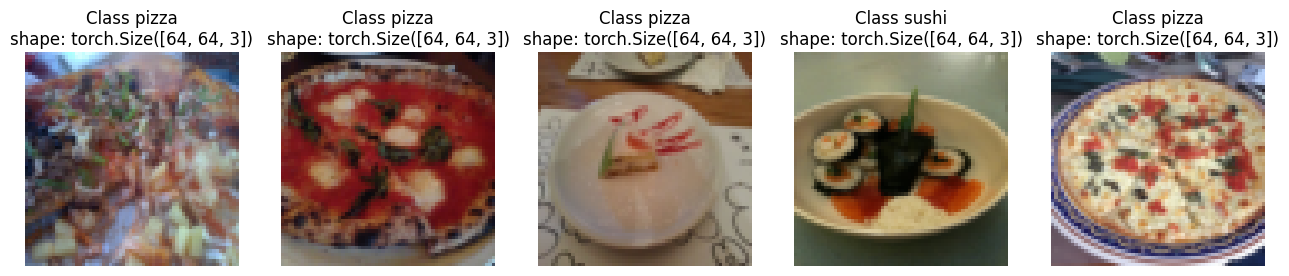

In [110]:
# Display random images from the ImageFoldercreated
display_random_images(train_data,
                      n=5,
                      classes=class_names,
                      seed=None)

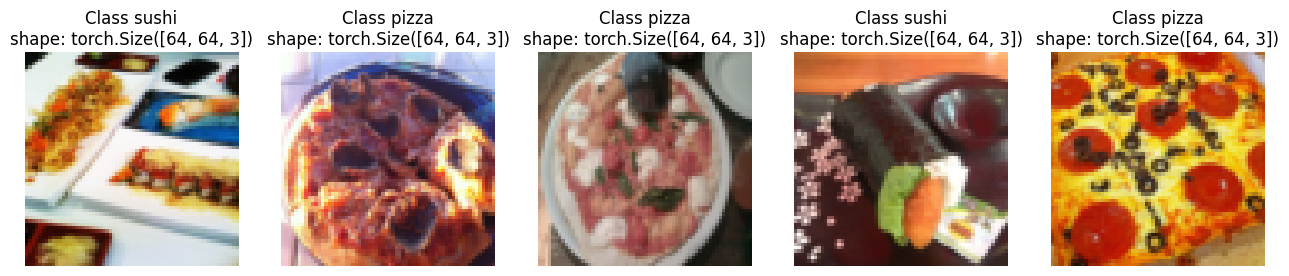

In [111]:
display_random_images(train_data,
                      n=5,
                      classes=class_names,
                      seed=42)

### 5.4 Turn custom loaded images into 'DataLoader'


In [112]:
from torch.utils.data import DataLoader
BATCH_SIZE = 32
NUM_WORKERS = 0
train_dataloader_custom = DataLoader(dataset=train_data_custom,
                                     batch_size=BATCH_SIZE,
                                     num_workers=NUM_WORKERS,
                                     shuffle=True)
test_dataloader_custom = DataLoader(dataset=test_data_custom,
                                    batch_size=BATCH_SIZE,
                                    num_workers=NUM_WORKERS,
                                    shuffle=False)

train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x12ad94bc0>,
 <torch.utils.data.dataloader.DataLoader at 0x12afcf050>)

In [113]:
# Get image and label from custom dataloader
img_custom, label_custom = next(iter(train_dataloader_custom))

# print out shapes
img_custom.shape, label_custom.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

## 6. Other forms of transforms (data augmentation)
Data augmentation is the process of artificially adding diversity to the training data
<br> In case of image data,this may mean applying various image transformations to the training images
<br>


In [114]:
from torchvision import transforms
train_transforms = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()

])
test_transforms = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor()
    ])



In [115]:
image_path

PosixPath('data/pizza_steak_sushi')

In [116]:
# Get all image Paths
image_path_list = list(image_path.glob("*/*/*.jpg"))
image_path_list[:10]

[PosixPath('data/pizza_steak_sushi/test/steak/296375.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/673127.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/894825.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/1868005.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/27415.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/1016217.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/1285886.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/502076.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/3424937.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/690177.jpg')]

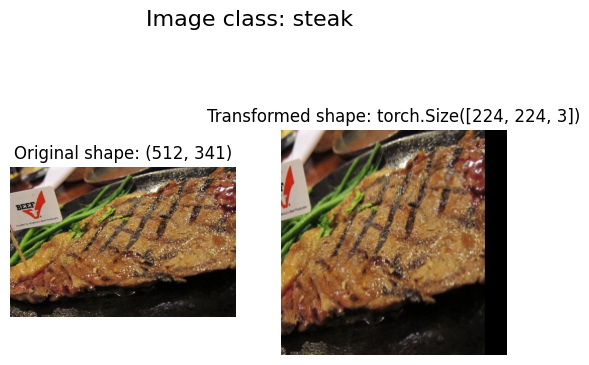

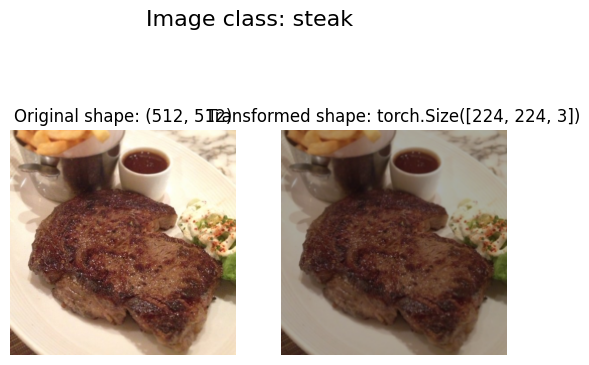

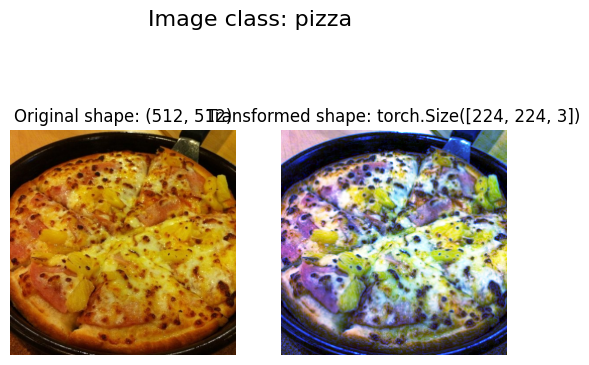

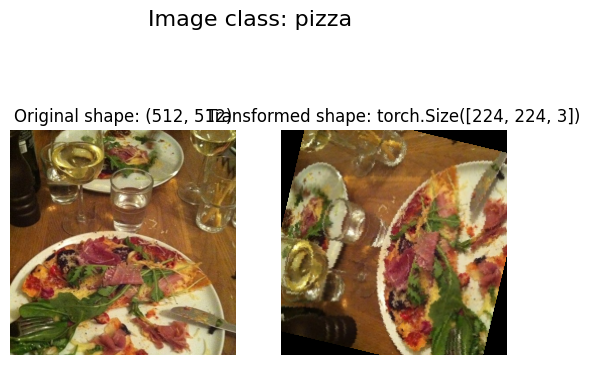

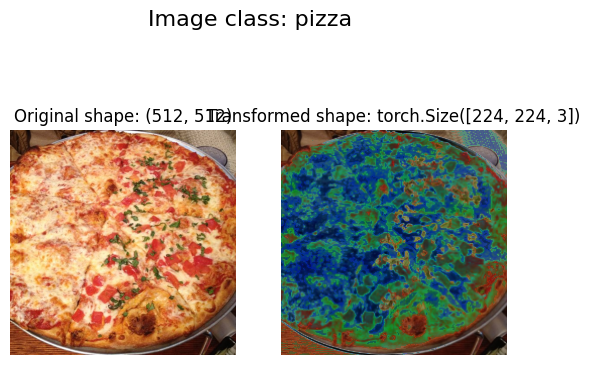

In [117]:
# Plot random transformed images
plot_transformed_images(
    image_paths = image_path_list,
    transform = train_transforms,
    n=5,
    seed=None
)

## 7. Model 0: TinyVGG without data augmentation
Let's replicate TInyVGG architecture from CNN explainer website

### 7.1 Creating transforms and loading data for Model 0

In [118]:
# Create simple transform
simple_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor()
])

In [139]:
# Load and transform data
from torchvision import datasets
train_data_simple = datasets.ImageFolder(root=train_dir,
                                         transform=simple_transform)
test_data_simple = datasets.ImageFolder(root=test_dir,
                                        transform=simple_transform)

# 2. Turn the datasets into DataLoaders
import os
from torch.utils.data import DataLoader

# Setup batch size and number of workers
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

# Create DataLoader's
train_dataloader_simple = DataLoader(dataset=train_data_simple,
                                     batch_size=BATCH_SIZE,
                                     num_workers=NUM_WORKERS,
                                     shuffle=True)
test_dataloader_simple = DataLoader(dataset=test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    num_workers=NUM_WORKERS,
                                    shuffle=False)

### 7.2 Make TinyVGG Baseclass


In [140]:
class TinyVGG(nn.Module):
    """
    Model architecture copying TinyVGG from:
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=1), # options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from?
            # It's because each layer of our network compresses and changes the shape of our input data.
            nn.Linear(in_features=hidden_units*16*16,
                      out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        x = self.conv_block_1(x)
        # print(x.shape)
        x = self.conv_block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x
        # return self.classifier(self.conv_block_2(self.conv_block_1(x))) # <- leverage the benefits of operator fusion

torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3, # number of color channels (3 for RGB)
                  hidden_units=10,
                  output_shape=len(train_data.classes)).to(device)
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

In [141]:
torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3, # Number of color channels
                  hidden_units=10,
                  output_shape=len(class_names)).to(torch.device("mps"))
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

### 7.3 Try a forward pass on a single image


In [142]:
# Get a single image batch
image_batch, label_batch = next(iter(train_dataloader_custom))
image_batch.shape, label_batch.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [143]:
image_batch = image_batch.to(torch.device("mps"))

model_0(image_batch).to('mps')

tensor([[0.0631, 0.0595, 0.0373],
        [0.0675, 0.0687, 0.0407],
        [0.0630, 0.0623, 0.0376],
        [0.0618, 0.0596, 0.0360],
        [0.0642, 0.0632, 0.0378],
        [0.0627, 0.0612, 0.0382],
        [0.0638, 0.0589, 0.0352],
        [0.0587, 0.0595, 0.0358],
        [0.0705, 0.0640, 0.0410],
        [0.0630, 0.0576, 0.0386],
        [0.0595, 0.0594, 0.0380],
        [0.0634, 0.0662, 0.0363],
        [0.0603, 0.0605, 0.0364],
        [0.0579, 0.0600, 0.0380],
        [0.0673, 0.0616, 0.0385],
        [0.0634, 0.0612, 0.0394],
        [0.0630, 0.0649, 0.0391],
        [0.0610, 0.0622, 0.0367],
        [0.0609, 0.0595, 0.0380],
        [0.0650, 0.0608, 0.0389],
        [0.0621, 0.0610, 0.0379],
        [0.0653, 0.0649, 0.0404],
        [0.0660, 0.0633, 0.0397],
        [0.0690, 0.0665, 0.0436],
        [0.0664, 0.0672, 0.0393],
        [0.0657, 0.0636, 0.0378],
        [0.0680, 0.0653, 0.0394],
        [0.0627, 0.0605, 0.0351],
        [0.0601, 0.0587, 0.0401],
        [0.062

### 7.4 Use 'torchinfo' to get an idea of the shapes going through the model


In [149]:
# Install torchinfo, import if its available
try:
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo

from torchinfo import summary

summary(model_0, input_size=[1, 3, 64, 64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 10, 64, 64]           280
│    └─ReLU: 2-2                         [1, 10, 64, 64]           --
│    └─Conv2d: 2-3                       [1, 10, 64, 64]           910
│    └─ReLU: 2-4                         [1, 10, 64, 64]           --
│    └─MaxPool2d: 2-5                    [1, 10, 32, 32]           --
├─Sequential: 1-2                        [1, 10, 16, 16]           --
│    └─Conv2d: 2-6                       [1, 10, 32, 32]           910
│    └─ReLU: 2-7                         [1, 10, 32, 32]           --
│    └─Conv2d: 2-8                       [1, 10, 32, 32]           910
│    └─ReLU: 2-9                         [1, 10, 32, 32]           --
│    └─MaxPool2d: 2-10                   [1, 10, 16, 16]           --
├─Sequentia

### 7.5 Create train and test loop functions
* 'train_step()' - takes in a model and dataloader and trains the model on the dataloader
* 'test_step()' - takes in a model and dataloader and evaluates the model on the data loader

In [150]:
# Create train_step()
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,):
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to the target device
        X, y = X.to('mps'), y.to('mps')

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate the loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate accuracy metric
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc +=  (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss /= len(dataloader)
    train_acc /= len(dataloader)
    return train_loss, train_acc



In [151]:
# Create a test step
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              optimizer: torch.optim.Optimizer):
    # Put modle in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference mode
    with torch.inference_mode():
        # Loop through dataloader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to the target device
            X, y = X.to('mps'), y.to('mps')

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate the loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate the accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_logits))

        # Adjust metrics to get avaerage loss and accuracy per batch
        test_loss /= len(dataloader)
        test_acc /= len(dataloader)
        return test_loss, test_acc





### 7.6 Creating a 'train()' function to combine 'train_step()' and 'test_step()'

In [152]:
from tqdm.auto import tqdm

# 1. Create a train function that takes in various model parameters
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          loss_fn: torch.nn.Module,
          optimizer: torch.optim.Optimizer,
          epochs: int = 5,
          device: torch.device = torch.device("cpu")) -> Dict:

    # 2. Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []}

    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model, train_dataloader, loss_fn, optimizer)
        test_loss, test_acc = test_step(model, test_dataloader, loss_fn, optimizer)

        # 4. Print out what's happening
        print(f"Epoch {epoch} | Train loss: {train_loss:.4f} | Test loss: {test_loss:.4f} | Test accuracy: {test_acc:.4f}")

        # 5. Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

        # 6. Return the filled results at the end of the epochs
    return results

### 7.7 Train and evaluate model 0


In [153]:
# Set random seeds
torch.manual_seed(42)
torch.mps.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 5

# Recreate an instnace of TinyVGG
model_0 = TinyVGG(input_shape=3,  # Number of color channels
                  hidden_units=10,
                  output_shape=len(class_names)).to(torch.device("mps"))

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss
optimizer = torch.optim.Adam(model_0.parameters(), lr=0.001)

# Start the timer
from timeit import Timer
start_time = timer()

# Train model 0
model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader_simple,
                        test_dataloader=test_dataloader_simple,
                        loss_fn=loss_fn,
                        optimizer=optimizer,
                        epochs=NUM_EPOCHS,
                        device=torch.device("mps"))

end_time = timer()
print(f"Total time: {end_time - start_time}")




  0%|          | 0/5 [00:00<?, ?it/s]

RuntimeError: linear(): input and weight.T shapes cannot be multiplied (32x31360 and 2560x3)